In [1]:

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from random import random, seed 

from sklearn import linear_model
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

from imageio import imread

In [2]:
def KFold(x,y,z, k, model, poly_deg, test_B, lambda_ = 0.5): 

    dataset = np.concatenate((x, y), axis = 1)

    from sklearn.cross_validation import train_test_split
    x_train, x_test, y_train, y_test = train_test_split(dataset, z, test_size=0.25)
    
 
    data = np.concatenate((x_train, y_train), axis = 1) #merging the train dataset to ise in Kfold
    
    KF_val = XY(x_test[:,0],x_test[:,1], poly_deg) #creating test matrix

    np.random.shuffle(data)
    
    # Initiating lists
    mse = []
    r2 = []
    beta_error_lst = []
    variance_lst = []
    beta_lst = []
    bias_lst = []
    
    split = np.array_split(data,k) 
    length = len(split[0])
    

    for i in range(0, k): 
 
        train = np.zeros((0, k))
        
        #Designating one part for test and t parts to train
        
        for j in range(0, k):
            if (i == j):
                test = split[j]
            else:
                train = np.concatenate((train, split[j]), axis = 0)    
            
        
        
        
        xy_comp_train = XY(train[:,0],train[:,1], poly_deg)
        
        beta = Beta_model(xy_comp_train, train[:,2], model, lambda_, test_B) #obtaining beta values from model
        
        z_predict_val = KF_val.dot(beta)
        
        xy_comp_test = XY(test[:,0],test[:,1], poly_deg)
        
        z_predict_test = xy_comp_test.dot(beta)
        

        #Appending values obtained from functions
        
        mse.append(MSE(y_test, z_predict_val))
        
        r2.append(R2(test[:,2], z_predict_test))
        
        variance_lst.append(Varience(z_predict_val))
        
        beta_lst.append(beta.reshape(-1,1))
        
        beta_error_lst.append(Sigma_2(xy_comp_test, test[:,2], z_predict_test, poly_deg))

        bias_lst.append(Bias(y_test, z_predict_val))
    
        #print mean_squared_error(y_test, z_predict_test)
    
    
    #True error/value equals the average over all the folds
    mse_error = np.mean(mse)
    r2_error = np.mean(r2)
    var = np.mean(variance_lst)
    bias = np.mean(bias_lst)

    beta_error = beta_error_lst[0] 
    for i in range (1, k):
        beta_error = beta_error + beta_error_lst[i]
    beta_error = beta_error/k

    beta = beta_lst[0] 
    for i in range (1, k):
        beta = beta + beta_lst[i]
    beta = beta/k
    
    
    #Calculating confidence interval
    beta_conf_int = np.c_[beta-(beta_error), beta+(beta_error)]
    
    #print bias, var, bias+var, mse_error
    #print beta
    return mse_error, r2_error, var , beta_conf_int, bias, beta, model, beta_error

In [73]:
def Sigma_2(xy_comp, z, z_predict, poly_deg): 
    
    #Calculating the error for each beta coefficient
    
    n = len(z)
    mean = (1./n ) * np.sum(z)

    sigma2 = (1./(n)) * (sum((z-mean)**2))

    beta_var = np.linalg.inv((xy_comp.T.dot(xy_comp))) * sigma2

    beta_conf = (np.sqrt(np.diag(beta_var))).reshape(-1,1) 
 
    return  beta_conf

In [64]:
def Franke(x,y, noise = False):
    #Franke function
    
    a = 0.75*np.exp(-(0.25*(9*x-2)**2)   - 0.25*((9*y-2)**2))
    b = 0.75*np.exp(-((9*x+1)**2)/49.0   - 0.10* (9*y+1))
    c = 0.50*np.exp(-(9*x-7)**2/4.0      - 0.25*((9*y-3)**2))
    d = -0.2*np.exp(-(9*x-4)**2          -       (9*y-7)**2)
    
    ret = a+b+c+d
        
    return ret

In [5]:
def MSE(comp, exac):
    #Calculating the mean squared error
        mse = 0
       
        exac = exac.ravel()
        comp = comp.ravel()
       
        for x , y in zip(comp, exac):
            mse += ((x-y)**2)
       
        return mse/len(comp)

In [6]:
def R2(x, x_t):
    #Calculating R2 
    
    x_t = x_t.reshape(-1, 1)
    x = x.reshape(-1, 1)
    x_sum = np.sum(x)    
    
    n = len(x)
    mean = (1./n)*x_sum       
    
    return 1- (sum((x-x_t)**2))/(sum((x-mean)**2))

In [7]:
def XY(x, y, poly_deg):
    #return np.c_[np.ones((x.shape)), x, y, x**2, x*y, y**2, x**3, x**2*y, x*y**2, y**3, x**4, x**3*y, x**2*y**2, x*y**3,y**4,x**5, x**4*y, x**3*y**2, x**2*y**3, x*y**4, y**5]
    
    #Creating the design matrix, using a loop for creating Xth degree (poly_deg) polynomial
    
    XY = []
    for i in range(poly_deg + 1):
        for j in range(poly_deg + 1 - i):
            XY.append(x**i * y**j)
            #print "x", i, " y", j
 
    XY_a = np.array(XY)  
    XY_a = XY_a.T     
    return XY_a

In [8]:
def Beta_model(xy_comp, z, string, lambda_ = 0.5, test_B = True):
    #Function taking a string argument to descide model used
    
    if (string.lower() == 'linear'): 
        #OLS regression, beta_Linear used for calculations, beta2 (sklearn) for comparing.
        
        beta_Linear = np.linalg.inv(xy_comp.T.dot(xy_comp)).dot(xy_comp.T).dot(z) 
        beta2 = LinearRegression(fit_intercept=False).fit(xy_comp, z)

        if test_B == True:
            return beta2.coef_
        else:
            return beta_Linear
    
    elif (string.lower() == 'ridge'):
        #Ridge regression
        
        I = np.identity(np.size(xy_comp, 1)) 
    
        beta_Ridge = np.linalg.inv(xy_comp.T.dot(xy_comp) + lambda_*(I)).dot(xy_comp.T).dot(z)
        return beta_Ridge 
    
    elif (string.lower() == 'lasso'):
        #Lasso regression, using sklearn code
        beta_Lasso = Lasso(alpha = lambda_, fit_intercept=False).fit(xy_comp, z)  
        return beta_Lasso.coef_
    
    else:
        print "model selection error"

In [9]:
def Varience(z_predict): 
    #print z_predict.shape
    var = np.var(z_predict)

    return var

def Bias(z, z_predict ): 
    #Simple function for returning the bias
    return np.mean( (z - np.mean(z_predict))**2 )

In [10]:
def plotSurface(X, Y, Z):
    #In large parts copied from project description
    fig = plt.figure()
    ax = fig.gca(projection='3d')   
   
    surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

    # Customize the z axis.
    ax.set_zlim(-0.10, 1.40)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
        

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z - Franke')
    
    # Add a color bar which maps values to colors.
    clb = fig.colorbar(surf, shrink=0.5, aspect=5)
    clb.ax.set_title('Level')

    plt.show()

In [29]:
def get_Z(z):
    #Returns the matrix reshaped for easier plotting 
    lst = []
    for p in z:
        p = p.reshape(1, -1)
        p = p[0]
        lst.append(p)
    Z =  np.array(lst)
    Z = Z/Z.max()
    return Z

In [43]:
def plot_Z(beta0, beta1, beta2, Z):
    
    #Plots OLS, Ridge and Lasso regression, as well as the residual.
        
    x = np.arange(0, 1, 0.001)
    y = np.arange(0, 1, 0.001)
    x, y = np.meshgrid(x,y)

    XY_ = XY(x, y, 5)

    Z_linear = XY_.dot(beta0)
    Z_ridge = XY_.dot(beta1)
    Z_lasso = XY_.dot(beta2)
    
    Z_linear = get_Z(Z_linear)
    Z_ridge = get_Z(Z_ridge)
    Z_lasso = get_Z(Z_lasso)
    
    print "Original model"
    plotSurface(x, y, Z)
    
    print "OLS fit"
    plotSurface(x, y, Z_linear)
    
    print "Ridge fit"
    plotSurface(x, y, Z_ridge)
    
    print "Lasso fit"
    plotSurface(x, y, Z_lasso)
    
    print "OLS residual"
    plotSurface(x, y, Z_linear - Z)
    
    print "Ridge residual"
    plotSurface(x, y, Z_ridge - Z)
    
    print "Lasso residual"
    plotSurface(x, y, Z_lasso - Z)


In [36]:

step = 0.001
cells = 1000
noise = 0.01


x = np.arange(0, 1, step)
y = np.arange(0, 1, step)
x, y = np.meshgrid(x,y)

noisy_x = x + noise * np.random.randn(len(x))
noisy_y = y + noise * np.random.randn(len(y))

z = Franke(x, y, False)

z_plot = z

x = x.reshape(-1, 1)
y = y.reshape(-1, 1)
z = z.reshape(-1, 1)

print z.shape, x.shape, y.shape

noisy_x = noisy_x.reshape(-1, 1)
noisy_y = noisy_y.reshape(-1, 1)

terrain1 = imread('SRTM_data_Norway_1.tif')
terrain1 = terrain1[:cells]
terrain1 = np.delete(terrain1 ,np.s_[cells:], axis=1) #Matrix needs to be nxn

terrain1 = terrain1/float(terrain1.max())
terrain1_plot = terrain1

terrain1 = terrain1.reshape(1, -1)
terrain1 = terrain1[0]
terrain1 = terrain1.reshape(-1, 1)




(1000000, 1) (1000000, 1) (1000000, 1)


In [37]:
mse_error, r2_error, var , beta_conf_int, bias, beta1, model, beta_error = KFold(noisy_x, noisy_y, z, 3,  "linear", 5, False)
mse_error, r2_error, var , beta_conf_int, bias, beta2, model, beta_error = KFold(noisy_x, noisy_y, z, 3,  "ridge", 5, False, 0.01)
mse_error, r2_error, var , beta_conf_int, bias, beta3, model, beta_error = KFold(noisy_x, noisy_y, z, 3,  "Lasso", 5, False, 0.000001)

In [79]:
plot_Z(beta1, beta2, beta3, z_plot)

KeyboardInterrupt: 

In [46]:
mse_error, r2_error, var , beta_conf_int, bias, beta4, model, beta_error = KFold(noisy_x, noisy_y, terrain1, 3,  "linear", 5, False)
mse_error, r2_error, var , beta_conf_int, bias, beta5, model, beta_error= KFold(noisy_x, noisy_y, terrain1, 3,  "ridge", 5, False, 0.00001)
mse_error, r2_error, var , beta_conf_int, bias, beta6, model, beta_error= KFold(noisy_x, noisy_y, terrain1, 3,  "Lasso", 5, False, 0.00001)

In [80]:
plot_Z(beta4, beta5, beta6, terrain1_plot)

NameError: name 'beta4' is not defined

In [15]:
#Created a function for easily changing the parameters 
def init(lambda_ = 0.00001, degree = 5, noise = 0.01, step = 0.01, cells = 100):
    #step = 0.001
    #cells = 1000
    #noise = 0.01


    x = np.arange(0, 1, step)
    y = np.arange(0, 1, step)
    x, y = np.meshgrid(x,y)

    noisy_x = x# + noise * np.random.randn(len(x))
    noisy_y = y #+ noise * np.random.randn(len(y))

    z = Franke(x, y, False) + noise * np.random.randn(len(y))

    z_plot = z

    x = x.reshape(-1, 1)
    y = y.reshape(-1, 1)
    z = z.reshape(-1, 1)

    print z.shape, x.shape, y.shape

    noisy_x = noisy_x.reshape(-1, 1)
    noisy_y = noisy_y.reshape(-1, 1)

    terrain1 = imread('SRTM_data_Norway_1.tif')
    terrain1 = terrain1[:cells]
    terrain1 = np.delete(terrain1 ,np.s_[cells:], axis=1) #Matrix needs to be nxn

    terrain1 = terrain1/float(terrain1.max())
    terrain1_plot = terrain1

    terrain1 = terrain1.reshape(1, -1)
    terrain1 = terrain1[0]
    terrain1 = terrain1.reshape(-1, 1)


    mse_error, r2_error, var , beta_conf_int, bias, beta1, model, beta_error = KFold(noisy_x, noisy_y, terrain1, 3,  "linear", degree, False, lambda_)
    
    print model, noise, beta_conf_int, beta1, beta_error
   
    mse_error, r2_error, var , beta_conf_int, bias, beta2, model, beta_error = KFold(noisy_x, noisy_y, terrain1, 3,  "ridge", degree, False, lambda_)
    
    print model, noise, beta_conf_int, beta2, beta_error
    
    mse_error, r2_error, var , beta_conf_int, bias, beta3, model, beta_error = KFold(noisy_x, noisy_y, terrain1, 3,  "lasso", degree, False, lambda_)
    
    print model, noise, beta_conf_int, beta3, beta_error

    
    

In [77]:
lst_bias = []
lst_var = []
step = 0.001

x = np.arange(0, 1, step)
y = np.arange(0, 1, step)
x, y = np.meshgrid(x,y)
z = Franke(x, y, False) + 0.01 * np.random.randn(len(y))

x = x.reshape(-1, 1)
y = y.reshape(-1, 1)
z = z.reshape(-1, 1)

for i in range(7):
        
    mse_error, r2_error, var , beta_conf_int, bias, beta1, model, beta_error = KFold(x, y, z, 3,  "linear", i, False, 0.00001)
    lst_var.append(var)
    lst_bias.append(bias)
    #print var, bias
print lst_var, lst_bias

[5.443961976134587e-32, 0.059324009541408346, 0.065962193619997389, 0.074802810488933488, 0.078493901633794091, 0.080765696292075292, 0.081702464896016139] [0.082730406478449967, 0.082762232522137602, 0.082929773371979085, 0.082739664707550786, 0.082605596670799433, 0.082753897724083564, 0.082956420885595822]


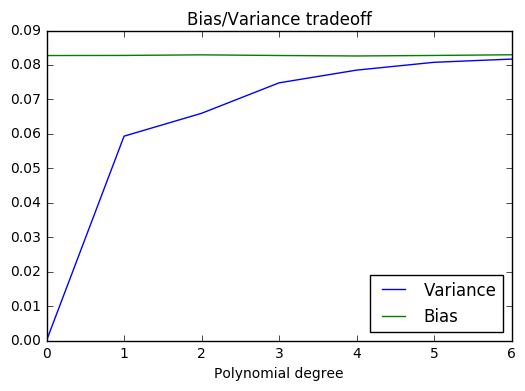

In [78]:
X_lst = [0,1,2,3,4,5,6]
plt.plot(X_lst,lst_var )
plt.plot(X_lst, lst_bias)
plt.legend(["Variance", "Bias"], loc = 'best')
plt.xlabel("Polynomial degree")
plt.title("Bias/Variance tradeoff")
plt.show()

In [70]:
mse_error


0.0012131513770466042